# Exploration des données

### Données obenues auprès de https://world.openfoodfacts.org


### Objectif du présent document

Explorer le jeu de données nettoyé dans le cadre d'une analyse univariée, bivariée et exploratoire des variables pertinentes retenues lors de la phase de préparation des données.


### Contexte de réalisation de l'étude

Notre étude du jeu de données devra être simple à comprendre pour un public néophyte. 
Nous devrons donc être particulièrement attentifs à la lisibilité et aux choix des graphiques pour illustrer notre propos.
    
### Direction de l'étude

Après une analyse univariée et bivariée du jeu de données, nous pourrons réaliser une ACP afin de comprendre les caractéristiques les plus discriminantes de notre ensemble de produits, ainsi qu'un partitionnement afin de plus simplement 
catégoriser les produits (beaucoups de catégories présentes dans le jeu).

Aussi nous pourrons effectuer quelques régressions pour étudier par exemple la correspondance entre nutriscore et nombre d'ingrédients dans un produit, la présence d'additifs ou d'allergènes.

Enfin, nous proposerons une métrique rendant compte de la qualité intrinsèque des produits, ainsi que de leur impact sur l'environnement, une métrique qui se voudra plus transparente envers le consommateur sur le bien fondé de la proposition de valeur qu'ils représentent.

### Idée d'application

Nous proposons un outil permettant au consommateur de mieux apprécier la qualité des produits qu'il consomme, et qui sera principalement basé sur l'appréciation des critères suivants :
- Le nustricore (valeur numérique)
- Le critère NOVA qui range en 4 catégories les produits en fonction de leur taux de transformation industrielle
- La présence d'addifits, d'allergènes, d'ingrédidents issus de l'huile de palme
- La disparité entre l'origine du produit, son lieu de transformation et la FRANCE
- L'appartenance du produit à un label BIO ou qui s'engage à prendre mieux soin des consommateurs
- Le type de packaging utilisé pour conditionner le produit

## Analyse univariée des valeurs nutritionnelles

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno

#### Chargement du jeu de données préparé

In [2]:
df = pd.read_csv('results\df_prepared.csv', index_col="Unnamed: 0")

C:\Users\jkomb\AppData\Local\Temp\ipykernel_3984\2985708659.py:1: DtypeWarning: Columns (21,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('results\df_prepared.csv', index_col="Unnamed: 0")


#### Créations des variables utiles

In [3]:
cols_pack = df.columns[df.columns.get_loc('carton'):df.columns.get_loc('suremballage')+1]
cols_categories = df.columns[df.columns.get_loc('categories_synth1'):df.columns.get_loc('categories_synth3')+1]
cols_labels = df.columns[df.columns.get_loc('bio_europe'):df.columns.get_loc('catégories_personnes')+1]
cols_ingredients = df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('ingredients_n')+1]
cols_allergens = df.columns[df.columns.get_loc('gluten'):df.columns.get_loc('moutarde')+1]
cols_additifs = df.columns[df.columns.get_loc('additives_n'):df.columns.get_loc('additif_niveau_danger')+1]
cols_palm = df.columns[df.columns.get_loc('ingredients_from_palm_oil_n'):df.columns.get_loc('ingredients_that_may_be_from_palm_oil_n')+1]
cols_nutri = df.columns[-8:].tolist()
col_val_nutri = cols_nutri.copy()
col_val_nutri.remove('nutrition-score-fr_100g')

In [59]:
size_title_graph = 17
y_title = 1

#### Données générales sur le jeu de données préparé

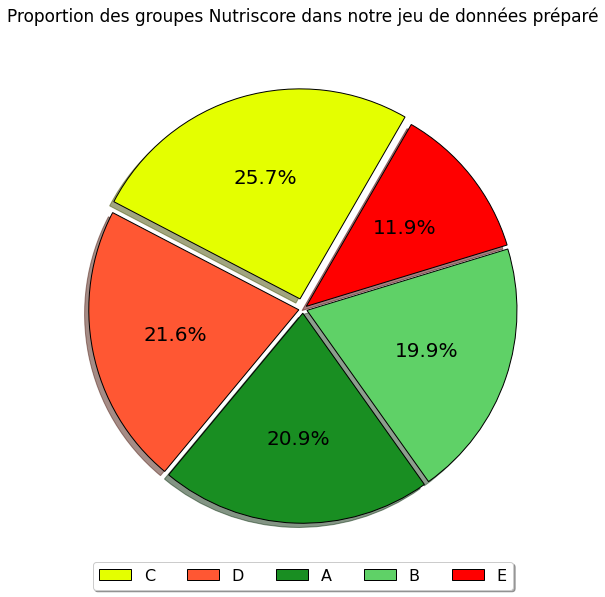

In [60]:
plt.figure(figsize=(8,8))
plt.suptitle('Proportion des groupes Nutriscore dans notre jeu de données préparé', y=y_title, size=size_title_graph)

pie_datas = df['nutrition_grade_fr'].value_counts().sort_values(ascending=False)
labels=df['nutrition_grade_fr'].str.upper().value_counts().sort_values(ascending=False).index
dict_colors={'A':'#198e22', 'B':'#5fd167', 'C':'#e4ff00', 'D':'#ff5733', 'E':'#ff0000'}
textprops = dict(size=20, color="black")
wedge_properties = {"edgecolor":"k",'linewidth': 1}

plt.pie(pie_datas, colors=[dict_colors[key] for key in labels],
        textprops=textprops,
        explode=[0.05,0.02,0.02,0.02,0.02],
        autopct='%1.1f%%',
        shadow=True, 
        wedgeprops=wedge_properties,
        startangle=60)

plt.tight_layout()
plt.legend(labels, loc="lower center", ncol=5, fontsize=16, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
plt.savefig('img\\Proportion des groupes Nutriscore dans notre jeu de données préparé.png')

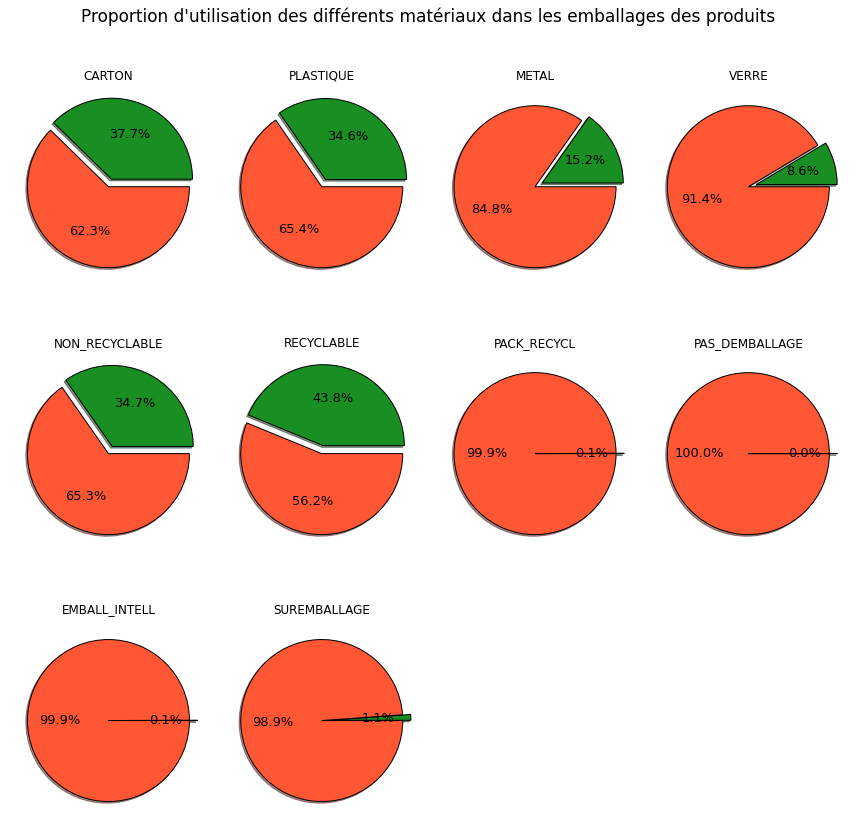

In [62]:
plt.figure(figsize=(12,12))
plt.suptitle("Proportion d'utilisation des différents matériaux dans les emballages des produits", y=y_title, 
             size=size_title_graph)
for col in cols_pack:
    plt.subplot(3,4, df.columns.get_loc(col)-df.columns.get_loc(cols_pack)+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion d'utilisation des différents matériaux dans les emballages des produits.png")

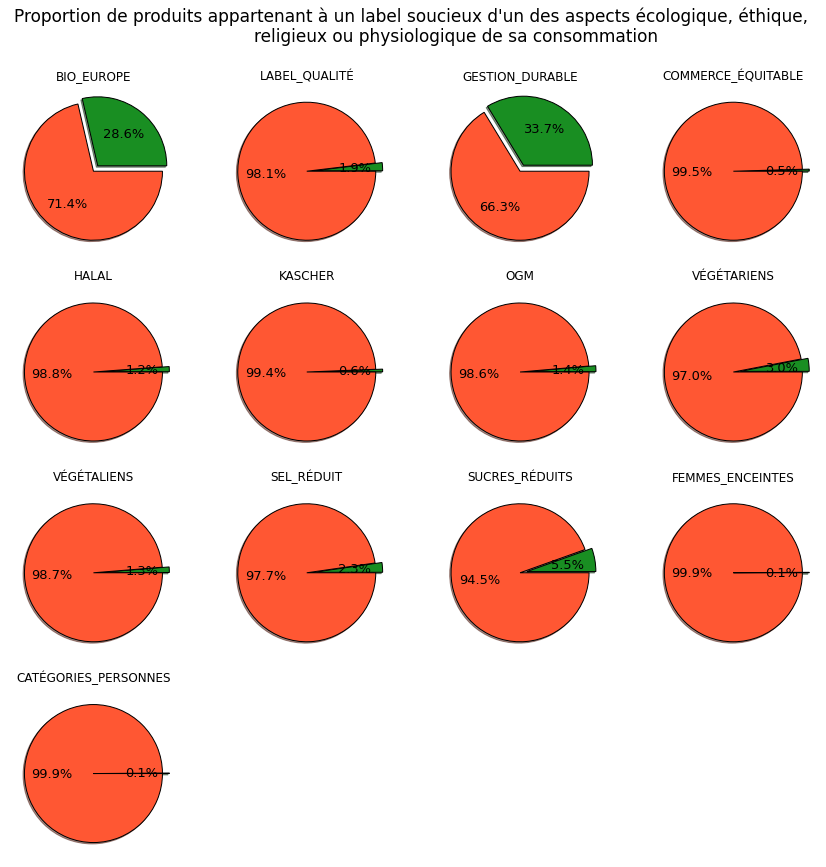

In [88]:
plt.figure(figsize=(12,12))
plt.suptitle("""Proportion de produits appartenant à un label soucieux d'un des aspects écologique, éthique, 
                religieux ou physiologique de sa consommation""", y=y_title, size=size_title_graph)
for col in cols_labels:
    plt.subplot(4,4, df.columns.get_loc(col)-df.columns.get_loc(cols_labels[0])+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion de produits appartenant à un label ou catégorie 'mieux consommer'.png")

* FEMMES_ENCEINTES = produits dont la consommation est déconseillé aux femmes enceintes
* CATÉGORIES_PERSONNES = produits dont la consommatione est déconseillé à certaines catégories de personnes

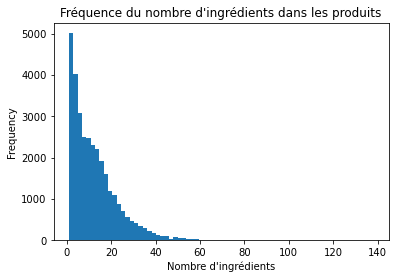

In [87]:
df[cols_ingredients[1]].plot.hist(bins=70)
plt.title("Fréquence du nombre d'ingrédients dans les produits")
plt.xlabel("Nombre d'ingrédients")
plt.savefig("img\Fréquence du nombre d'ingrédients dans les produits.png")

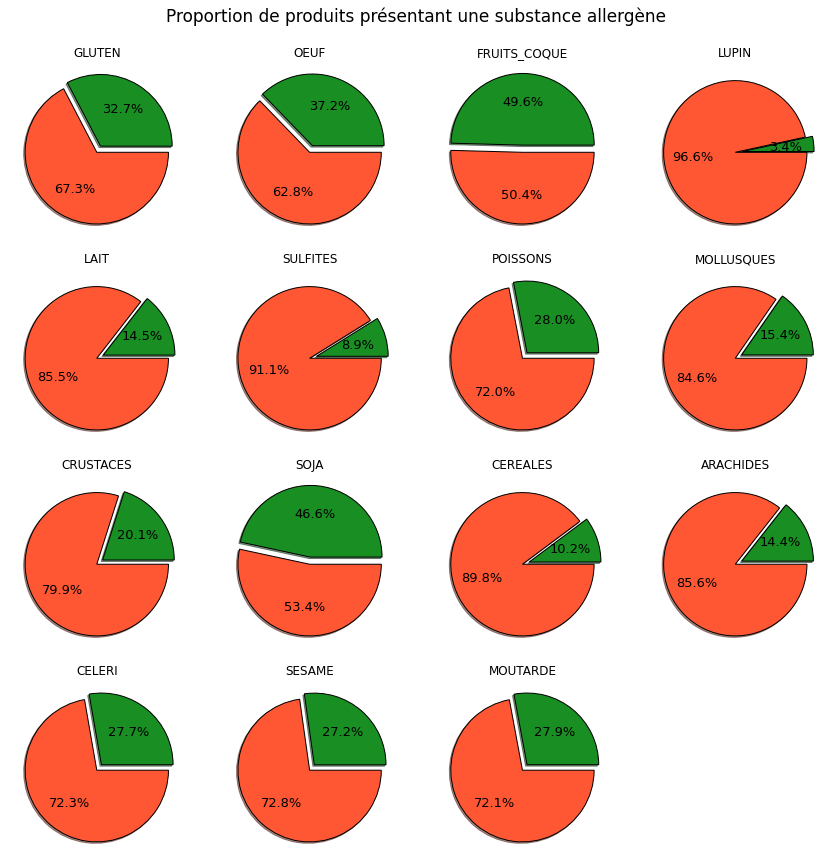

In [90]:
plt.figure(figsize=(12,12))
plt.suptitle("""Proportion de produits présentant une substance allergène""", y=y_title, size=size_title_graph)
for col in cols_allergens:
    plt.subplot(4,4, df.columns.get_loc(col)-df.columns.get_loc(cols_allergens[0])+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=[0.1,0],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion de produits présentant une substance allergène.png")

In [98]:
df[cols_palm[0]].value_counts()

0.0    29986
1.0     2241
2.0       40
Name: ingredients_from_palm_oil_n, dtype: int64

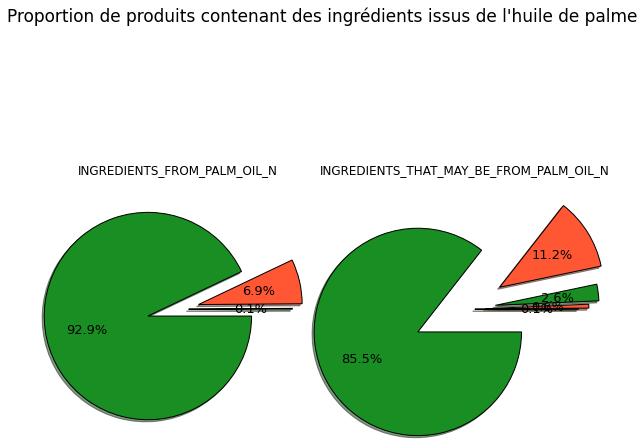

In [110]:
plt.figure(figsize=(8,8))
plt.suptitle("""Proportion de produits contenant des ingrédients issus de l'huile de palme""", y=y_title, size=size_title_graph)
explode = [[0.1,0.2,0.3],[0.1,0.2,0.3,0.4,0.5]]
for col in cols_palm:
    plt.subplot(1,2, df.columns.get_loc(col)-df.columns.get_loc(cols_palm[0])+1)
    plt.pie(x=df[col].value_counts().sort_values(ascending=True),
           colors=['#198e22', '#ff5733'],
           textprops=dict(size=13, color="black"),
           explode=explode[df.columns.get_loc(col)-df.columns.get_loc(cols_palm[0])],
           autopct='%1.1f%%',
           shadow=True, 
           wedgeprops=wedge_properties);
    plt.title(col.upper())

plt.tight_layout()
plt.savefig("img\\Proportion de produits contenant des ingrédients issus de l'huile de palme.png")

#### Analyse univariée des variables nutritionnelles

Observons plus en détail les caractéristiques des distributions des valeurs nutritionnelles :

DISTRIBUTION DES VALEURS NUTRITIONNELLES


--------------------
ENERGY_100G


moyenne:
 894.8242014582067
médiane:
 698.0
mode:
 [0.]
variance:
 467256.91738459846
écart-type:
 683.5619338323328
skwewness:
 0.6784769271210634
kurtosis:
 -0.5771996524419354


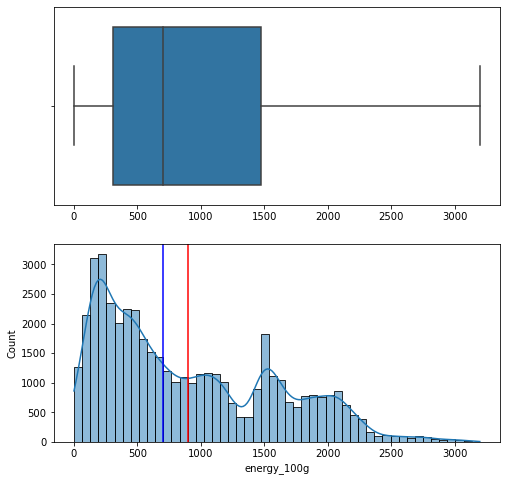

--------------------
SATURATED-FAT_100G


moyenne:
 3.160266755776442
médiane:
 1.4
mode:
 [0.]
variance:
 16.716508070373134
écart-type:
 4.088582648103513
skwewness:
 1.5766283174417473
kurtosis:
 1.5739241864977584


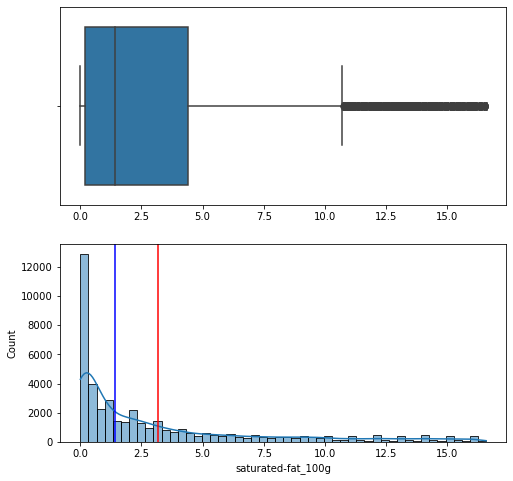

--------------------
CARBOHYDRATES_100G


moyenne:
 24.978850937212467
médiane:
 13.0
mode:
 [0.]
variance:
 645.7992773373986
écart-type:
 25.412581083734857
skwewness:
 0.9329524037262567
kurtosis:
 -0.5425094590348305


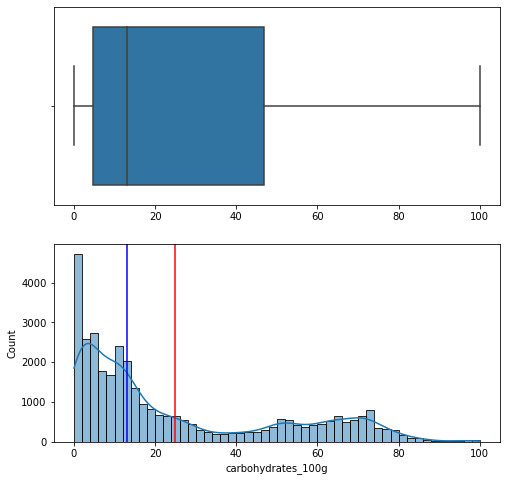

--------------------
SUGARS_100G


moyenne:
 8.213902012348147
médiane:
 3.7
mode:
 [0.]
variance:
 99.25066827420808
écart-type:
 9.962462962250253
skwewness:
 1.5202360349346151
kurtosis:
 1.344504900043574


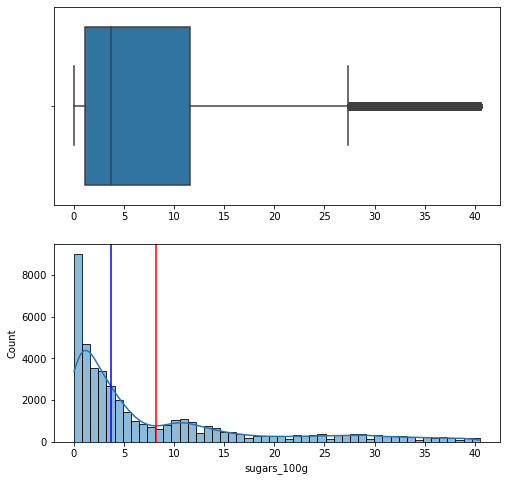

--------------------
FIBER_100G


moyenne:
 1.8421970752596728
médiane:
 1.4
mode:
 [0.]
variance:
 3.695680528555674
écart-type:
 1.9224152851441008
skwewness:
 1.0943843050728939
kurtosis:
 0.5429370927527524


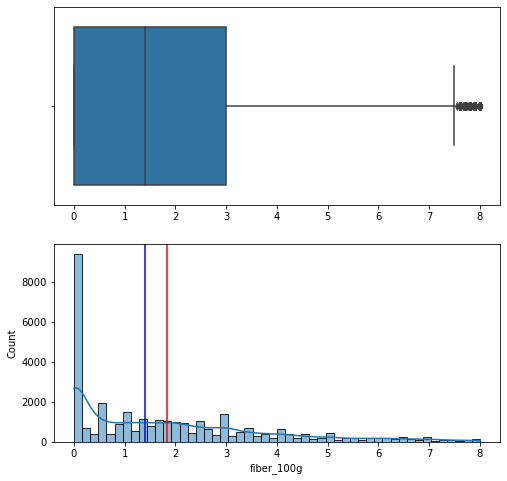

--------------------
PROTEINS_100G


moyenne:
 6.489336974441732
médiane:
 5.5
mode:
 [0.]
variance:
 31.922533892076764
écart-type:
 5.6500029992980325
skwewness:
 0.9505630271772301
kurtosis:
 0.22313026049630302


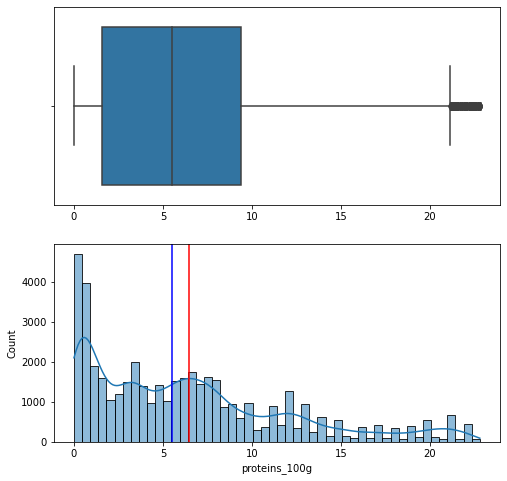

--------------------
SODIUM_100G


moyenne:
 0.27797927381235266
médiane:
 0.236220472440945
mode:
 [0.]
variance:
 0.07083474258759857
écart-type:
 0.26614797122577993
skwewness:
 0.8186990669767249
kurtosis:
 -0.13719441640525254


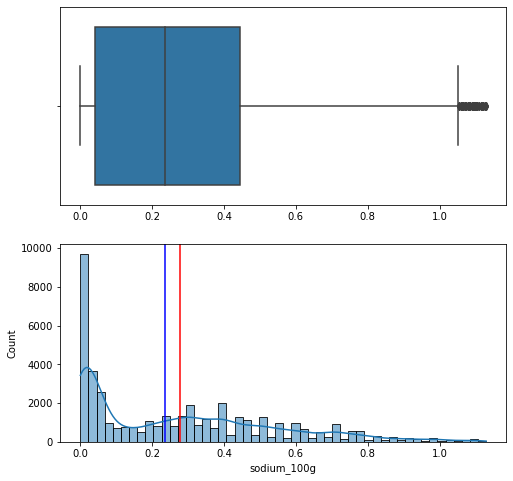

In [6]:
print('DISTRIBUTION DES VALEURS NUTRITIONNELLES')
print('\n')
for col in col_val_nutri:
    subset = df[col]
    print("-"*20)
    print(col.upper())
    print('\n')
    print("moyenne:\n",subset.mean())
    print("médiane:\n",subset.median())
    print("mode:\n",subset.mode().values)
    print("variance:\n",subset.var(ddof=0))
    print("écart-type:\n",subset.std(ddof=0))
    print("skwewness:\n",subset.skew())
    print("kurtosis:\n",subset.kurtosis())
    fig = plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    ax1 = sns.boxplot(x=subset)
    ax1.set(xlabel=None)
    plt.subplot(2,1,2)
    ax2 = sns.histplot(x=df[col], kde=True, bins=50)
    plt.axvline(x=df[col].mean(), color='r')
    plt.axvline(x=df[col].median(), color='b')
    plt.show()

#### Étudions maintenant la relation entre le nutriscore et les différentes valeurs nutritionnelles:

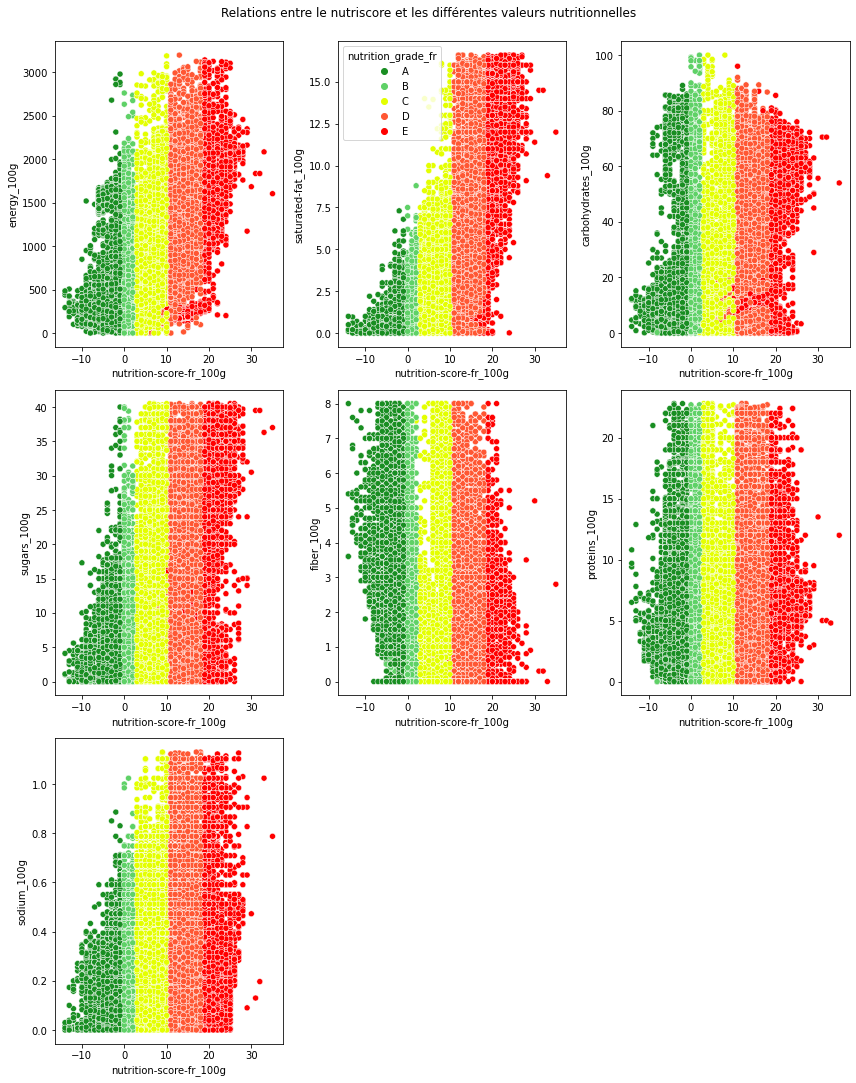

In [7]:
plt.figure(figsize=(12,15))
plt.suptitle('Relations entre le nutriscore et les différentes valeurs nutritionnelles', y=1)
hue = df['nutrition_grade_fr'].str.upper()
palette_nutri = sns.color_palette(['#198e22', '#5fd167', '#e4ff00', '#ff5733', '#ff0000'])

for col in col_val_nutri:
    plt.subplot(3,3,col_val_nutri.index(col)+1)
    if col_val_nutri.index(col)==1:
        sns.scatterplot(data=df, x='nutrition-score-fr_100g', y=col, 
                        hue=hue,
                        palette=palette_nutri,
                        legend='brief')
    else:
        sns.scatterplot(data=df,
                        x='nutrition-score-fr_100g', y=col, 
                        hue=hue,
                        palette=palette_nutri, legend=False)

plt.tight_layout()
plt.savefig('img\\Relations entre nutriscore et valeurs nutritionnelles.png')
plt.show();

Nous observons que :
- plus un produit est énergétique, plus son nutriscore a tendance à être élevé
- il en va de même pour la teneur en graisses saturées
- la tendance pour les glucides est moins prononcée, voire neutre
- plus un produit contient de sucres, plus son nutriscore a tendance à être élevé
- plus un produit contient de fibres, moins son nutriscore a tendance à être élevé
- de même que pour les glucides, la tendance pour les protéines semble neutre
- plus un produit contient de sodium, plus son nutriscore est élevé

Pour avoir une meilleure représentation des tendances qui semblent se dégager, nous préférons tracer ces relations sous forme de boîtes à moustaches comme ci-après :

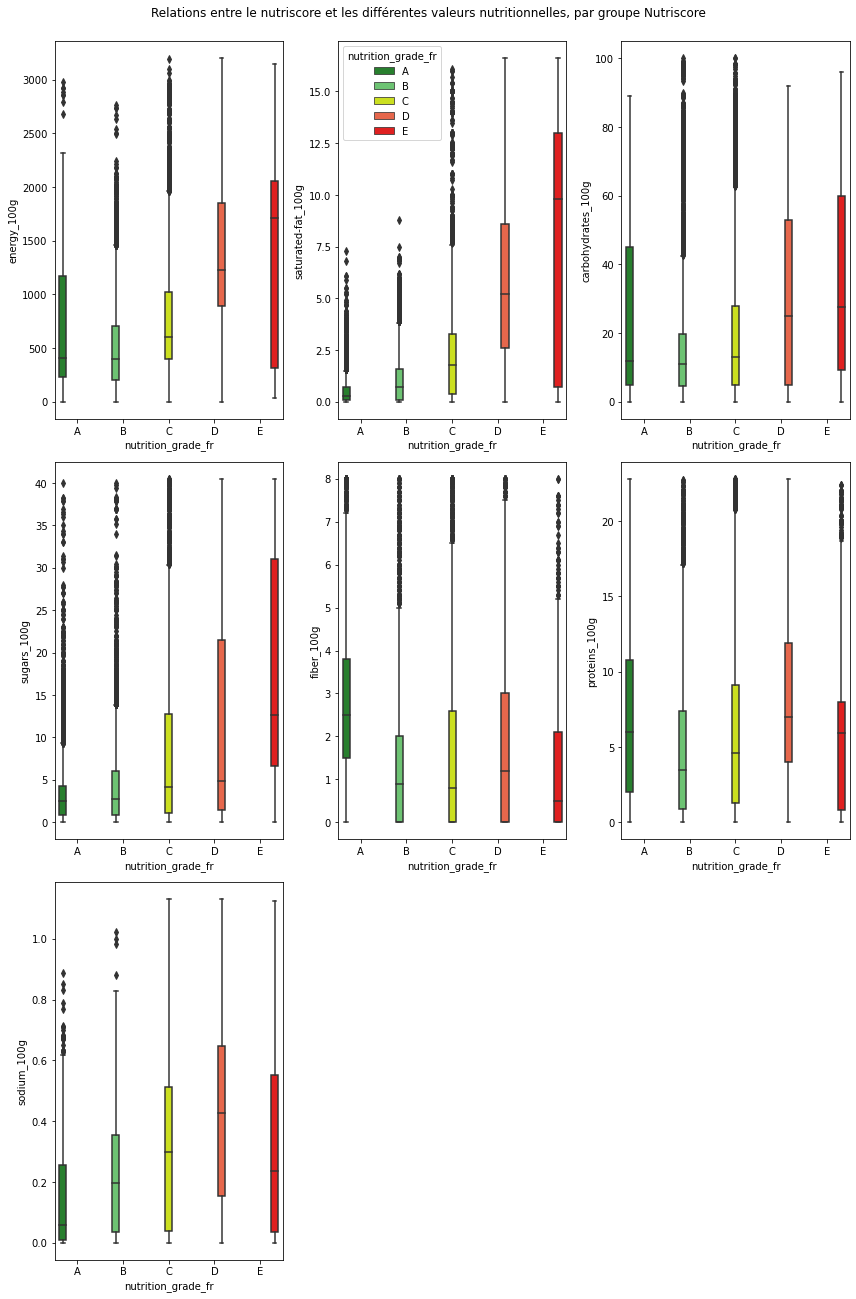

In [8]:
plt.figure(figsize=(12,18))
plt.suptitle('Relations entre le nutriscore et les différentes valeurs nutritionnelles, par groupe Nutriscore', y=1)
nutri_color =  sns.color_palette(['#198e22', '#5fd167', '#e4ff00', '#ff5733', '#ff0000'])

for col in col_val_nutri:
    if col_val_nutri.index(col)==1:
        plt.subplot(3,3,col_val_nutri.index(col)+1)
        sns.boxplot(x=df['nutrition_grade_fr'].str.upper(), y=df[col], 
                            hue=df['nutrition_grade_fr'].str.upper().sort_values(ascending=True),
                            palette=nutri_color)
    else:
        plt.subplot(3,3,col_val_nutri.index(col)+1)
        sns.boxplot(x=df['nutrition_grade_fr'].str.upper(), y=df[col], 
                            hue=df['nutrition_grade_fr'].str.upper().sort_values(ascending=True),
                            palette=nutri_color)
        plt.legend('',frameon=False)

plt.tight_layout()
plt.savefig('img\\Relations entre nutriscore et valeurs nutritionnelles, par groupe Nutriscore.png')
plt.show();

Nous allons évaluer si les moyennes des teneurs en nutriment pour chaque valeur nutritionnelle sont significativement différentes, et allons donc réaliser pour cela une analyse de variance (ANOVA) :